In [59]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from torchmetrics import functional as FM
import matplotlib.pyplot as plt
    

In [2]:

class MnistClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
        
    def forward(self, batch):
        return self.model(batch)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = FM.accuracy(logits, y)
        loss = F.cross_entropy(logits, y)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = FM.accuracy(logits, y)
        loss = F.cross_entropy(logits, y)
        metrics = {'test_acc': acc, 'test_loss': loss}
        self.log_dict(metrics)
        
    def predict_step(self, batch, batch_idx):
        return self(batch)

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
dataset = MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [55000, 5000])
test = MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

In [5]:
model = MnistClassifier()
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)
trainer.fit(model, DataLoader(train, batch_size=1024, num_workers=4), DataLoader(val, batch_size=1024, num_workers=4))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.3 K
-------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 59/59 [00:14<00:00,  4.02it/s, loss=0.0393, v_num=22]


In [6]:
trainer.test(dataloaders=DataLoader(test, batch_size=256, num_workers=4))

d:\pythonenv\mlenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at c:\Users\lijm1\Desktop\Pytorch-Lightning-practice\lightning_logs\version_22\checkpoints\epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\lijm1\Desktop\Pytorch-Lightning-practice\lightning_logs\version_22\checkpoints\epoch=9-step=540.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 44.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9715999960899353
        test_loss           0.08902772516012192
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9715999960899353, 'test_loss': 0.08902772516012192}]

In [8]:
model.eval()

MnistClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [41]:
pred = []
for i in range(10):
    _, label = torch.max(model(test.data[i].unsqueeze(dim=0) / 255), 1)
    pred.append(label.item())

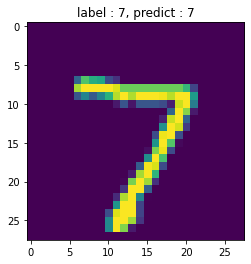

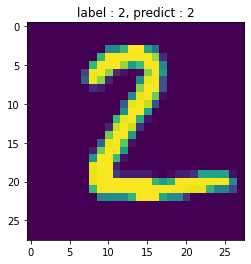

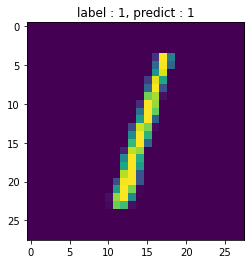

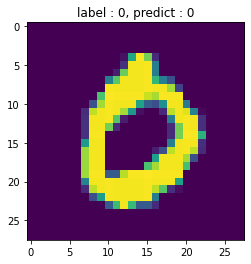

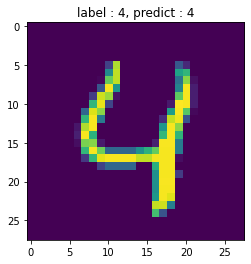

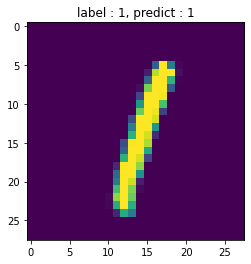

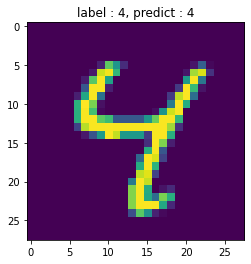

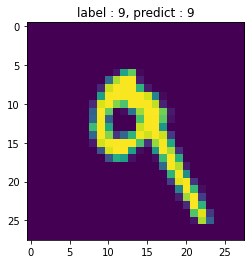

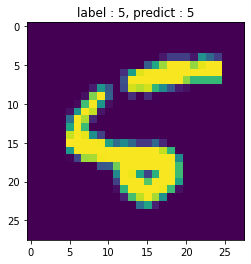

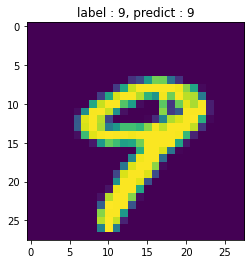

In [58]:
for i in range(10):
    plt.imshow(test.data[i])
    plt.title(f'label : {test.test_labels[i]}, predict : {pred[i]}')
    plt.show()